# Лекция 13: Анализ временных рядов и прогнозирование

## Содержание лекции

1. Введение во временные ряды
2. Компоненты временных рядов
3. Стационарность и тесты
4. Классические модели (ARIMA, SARIMA)
5. Машинное обучение для временных рядов
6. Валидация и метрики
7. Практические примеры

## 1. Введение во временные ряды

### Что такое временной ряд?

**Временной ряд** - это последовательность наблюдений, упорядоченных по времени: $y_1, y_2, y_3, ..., y_t, ..., y_n$

### Ключевые отличия от обычных данных:

1. **Временная зависимость**: наблюдения не независимы
2. **Автокорреляция**: значение коррелирует с прошлыми значениями
3. **Порядок важен**: нельзя перемешивать данные!

### Применения:

- 📈 **Финансы**: прогноз цен акций, курсов валют
- 🏪 **Ритейл**: планирование запасов, прогноз продаж
- 🌡️ **IoT**: мониторинг датчиков, предсказание сбоев
- 🏥 **Медицина**: мониторинг пациентов, эпидемиология
- ⚡ **Энергетика**: прогноз потребления электроэнергии

In [2]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Машинное обучение
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Настройка графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("✅ Библиотеки успешно импортированы")

✅ Библиотеки успешно импортированы


In [ ]:
pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.5 MB 4.5 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.5 MB 3.2 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/9.5 MB 3.2 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/9.5 MB 3.2 MB/s eta 0:00:03
   ------------- -------------------------- 3.1/9.5 MB 2.6 MB/s eta 0:00:03
   --------------- ------------------------ 3.7/9.5 MB 2.5 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.5 MB 2.5 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.5 MB 2.3 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.5 MB 2.4 MB/s eta 0:00:02
   ----------------------- ---------------- 5.5/9.5 MB 2.4 MB/s eta 0:00:02
   --------------------------- --


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Компоненты временных рядов

### Декомпозиция временного ряда

**Аддитивная модель:** $Y_t = T_t + S_t + R_t$

**Мультипликативная модель:** $Y_t = T_t \times S_t \times R_t$

где:
- **$T_t$** - тренд (долгосрочное направление)
- **$S_t$** - сезонность (повторяющиеся паттерны)
- **$R_t$** - остаток/шум (случайная компонента)

### Компоненты:

1. **Тренд**: линейный, экспоненциальный, полиномиальный
2. **Сезонность**: дневная, недельная, месячная, годовая
3. **Циклы**: долгосрочные колебания (> 1 года)
4. **Остаток**: должен быть белым шумом

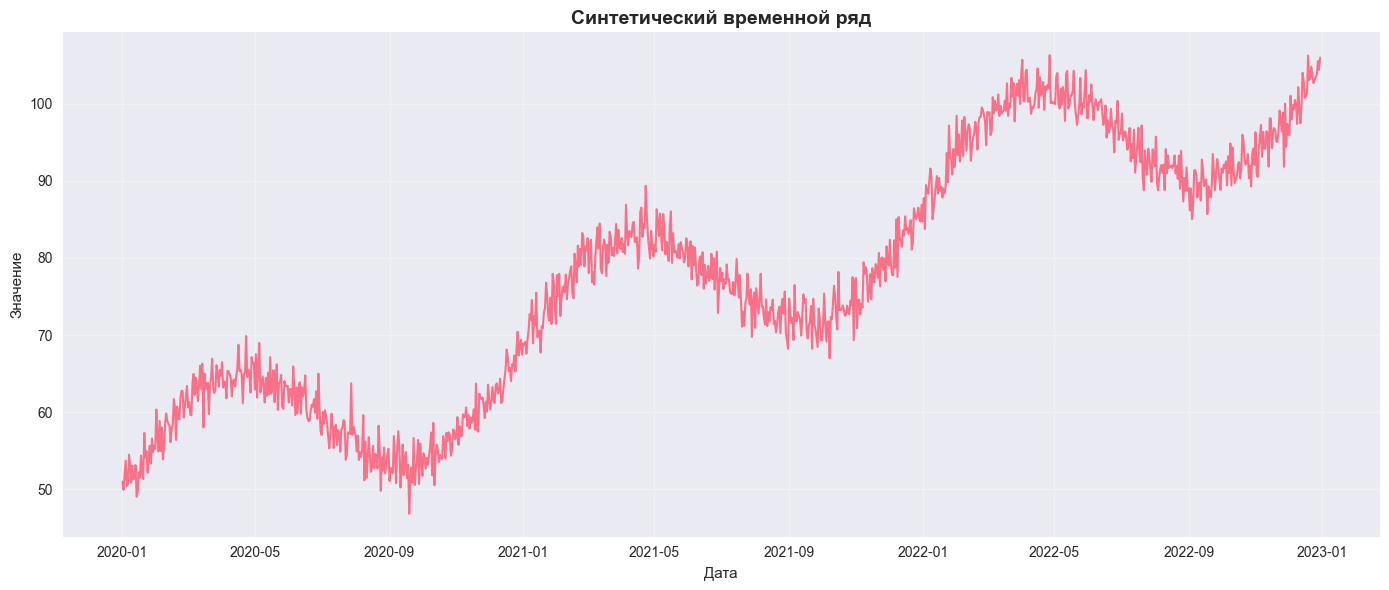

Размер временного ряда: 1095
Период: с 2020-01-01 по 2022-12-30

Описательная статистика:
count    1095.000000
mean       77.415912
std        15.761672
min        46.821328
25%        63.250696
50%        77.385027
75%        91.762273
max       106.294158
Name: value, dtype: float64


In [3]:
# Создание синтетического временного ряда с трендом и сезонностью
np.random.seed(42)
n = 365 * 3  # 3 года дневных данных
time = np.arange(n)

# Компоненты
trend = 0.05 * time  # Линейный тренд
seasonal = 10 * np.sin(2 * np.pi * time / 365)  # Годовая сезонность
noise = np.random.normal(0, 2, n)  # Шум

# Аддитивная модель
ts_additive = trend + seasonal + noise + 50

# Создание DataFrame
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
df = pd.DataFrame({'value': ts_additive}, index=dates)

# Визуализация исходного ряда
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], linewidth=1.5)
plt.title('Синтетический временной ряд', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Размер временного ряда: {len(df)}")
print(f"Период: с {df.index[0].date()} по {df.index[-1].date()}")
print(f"\nОписательная статистика:")
print(df['value'].describe())

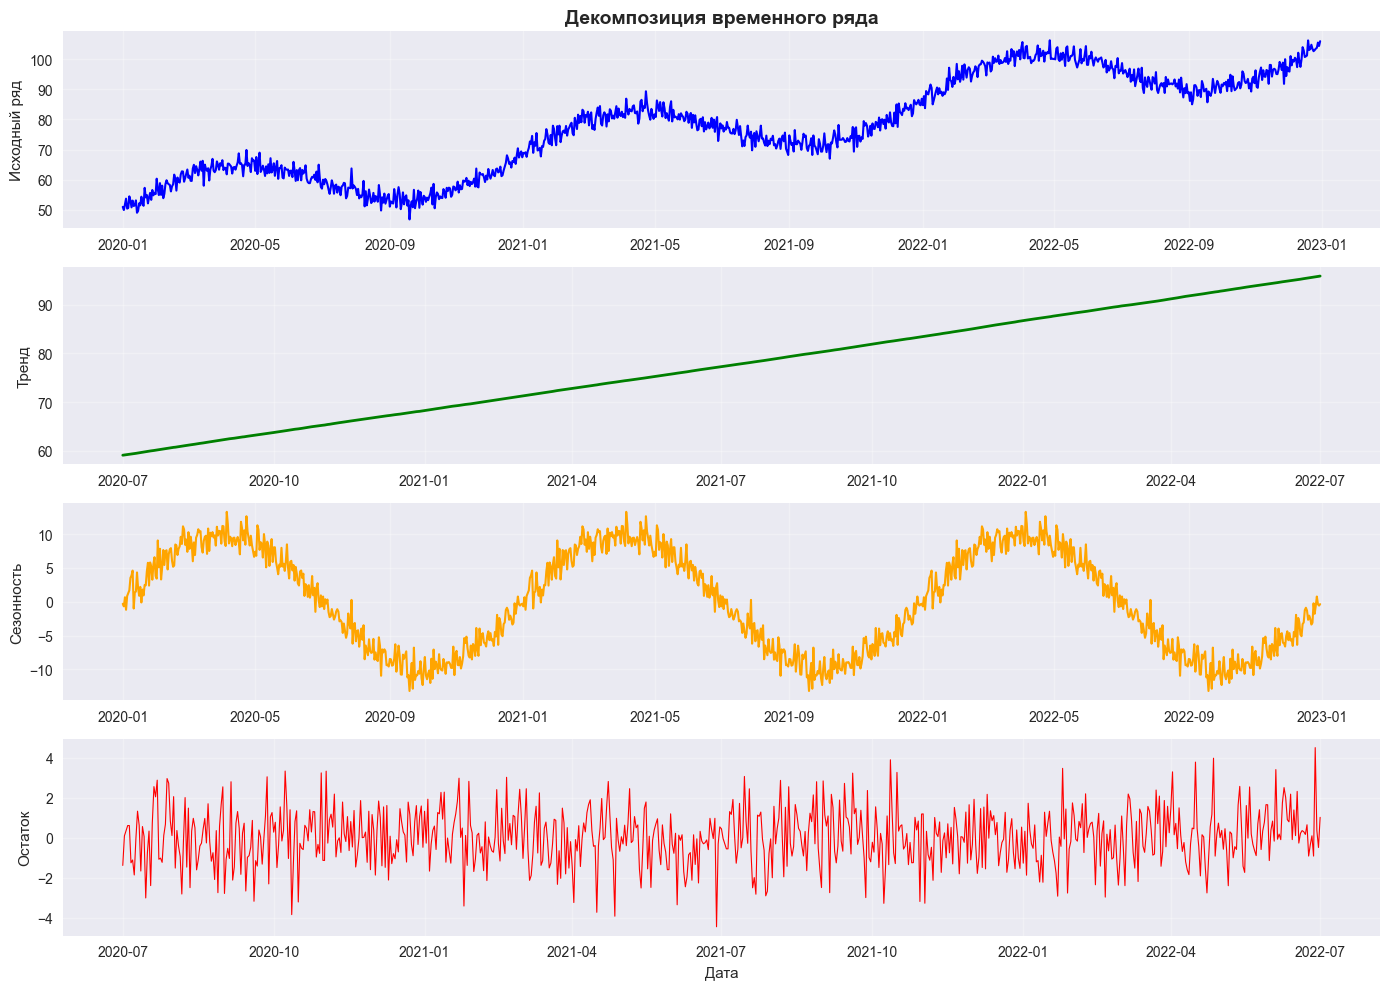

Анализ компонентов:
Тренд: средний рост = 0.0503 в день
Сезонность: амплитуда = 26.49
Остаток: std = 1.39


In [4]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(df['value'], model='additive', period=365)

# Визуализация компонентов
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Исходный ряд
axes[0].plot(df.index, df['value'], color='blue', linewidth=1.5)
axes[0].set_ylabel('Исходный ряд')
axes[0].set_title('Декомпозиция временного ряда', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Тренд
axes[1].plot(decomposition.trend, color='green', linewidth=2)
axes[1].set_ylabel('Тренд')
axes[1].grid(True, alpha=0.3)

# Сезонность
axes[2].plot(decomposition.seasonal, color='orange', linewidth=1.5)
axes[2].set_ylabel('Сезонность')
axes[2].grid(True, alpha=0.3)

# Остаток
axes[3].plot(decomposition.resid, color='red', linewidth=0.8)
axes[3].set_ylabel('Остаток')
axes[3].set_xlabel('Дата')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Анализ компонентов:")
print(f"Тренд: средний рост = {decomposition.trend.diff().mean():.4f} в день")
print(f"Сезонность: амплитуда = {decomposition.seasonal.max() - decomposition.seasonal.min():.2f}")
print(f"Остаток: std = {decomposition.resid.std():.2f}")

## 3. Стационарность и преобразования

### Что такое стационарность?

**Стационарный временной ряд** - ряд, статистические свойства которого не меняются со временем.

**Условия слабой стационарности:**
1. Константное среднее: $E[Y_t] = \mu$ (не зависит от t)
2. Константная дисперсия: $Var(Y_t) = \sigma^2$ (не зависит от t)
3. Автокорреляция зависит только от лага: $Cov(Y_t, Y_{t-k}) = \gamma_k$

### Почему важна стационарность?

Многие модели (ARIMA, VAR) требуют стационарности для корректной работы.

### Тесты на стационарность:

1. **ADF Test (Augmented Dickey-Fuller)**
   - H₀: ряд нестационарен
   - H₁: ряд стационарен
   - p-value < 0.05 → отвергаем H₀ → стационарен

2. **KPSS Test**
   - H₀: ряд стационарен
   - H₁: ряд нестационарен
   - p-value < 0.05 → отвергаем H₀ → нестационарен

In [6]:
# Функция для тестирования стационарности
def test_stationarity(timeseries, title='Временной ряд'):
    """
    Тестирование стационарности с помощью ADF и KPSS тестов
    """
    print(f"\n{'='*60}")
    print(f"Тестирование стационарности: {title}")
    print(f"{'='*60}")
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna(), autolag='AIC')
    print("\n📊 ADF Test (Augmented Dickey-Fuller):")
    print(f"   ADF Statistic: {adf_result[0]:.6f}")
    print(f"   p-value: {adf_result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.3f}")
    
    if adf_result[1] < 0.05:
        print("   ✅ Вывод: Ряд СТАЦИОНАРЕН (p < 0.05)")
        adf_conclusion = "Стационарен"
    else:
        print("   ❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p >= 0.05)")
        adf_conclusion = "Нестационарен"
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')
    print("\n📊 KPSS Test:")
    print(f"   KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"   p-value: {kpss_result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value:.3f}")
    
    if kpss_result[1] >= 0.05:
        print("   ✅ Вывод: Ряд СТАЦИОНАРЕН (p >= 0.05)")
        kpss_conclusion = "Стационарен"
    else:
        print("   ❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p < 0.05)")
        kpss_conclusion = "Нестационарен"
    
    print(f"\n🎯 Итоговый вывод: ADF={adf_conclusion}, KPSS={kpss_conclusion}")
    
    return adf_result[1], kpss_result[1]

# Тестирование исходного ряда
adf_p, kpss_p = test_stationarity(df['value'], 'Исходный ряд')


Тестирование стационарности: Исходный ряд

📊 ADF Test (Augmented Dickey-Fuller):
   ADF Statistic: -0.598782
   p-value: 0.871257
   Critical Values:
      1%: -3.436
      5%: -2.864
      10%: -2.568
   ❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p >= 0.05)

📊 KPSS Test:
   KPSS Statistic: 4.497963
   p-value: 0.010000
   Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p < 0.05)

🎯 Итоговый вывод: ADF=Нестационарен, KPSS=Нестационарен


E:\GENAI\_tmp\ipykernel_5372\2130437989.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')


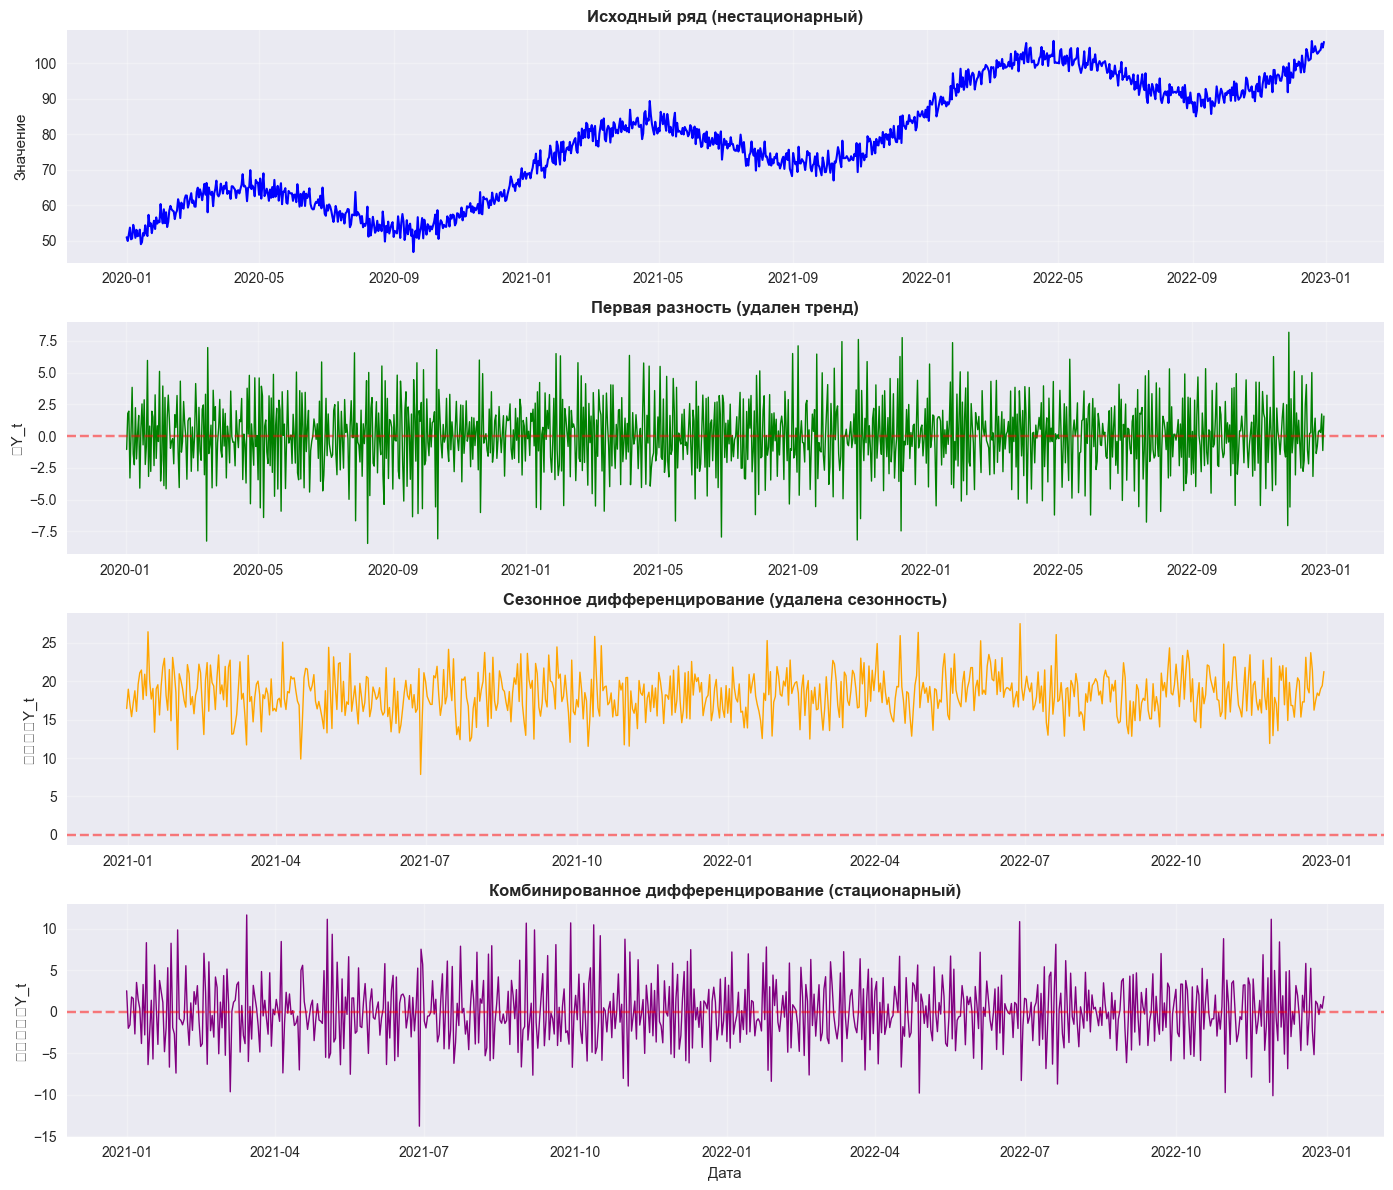


ТЕСТИРОВАНИЕ ПРЕОБРАЗОВАНИЙ

Тестирование стационарности: Первая разность

📊 ADF Test (Augmented Dickey-Fuller):
   ADF Statistic: -5.387246
   p-value: 0.000004
   Critical Values:
      1%: -3.436
      5%: -2.864
      10%: -2.568
   ✅ Вывод: Ряд СТАЦИОНАРЕН (p < 0.05)

📊 KPSS Test:
   KPSS Statistic: 0.044109
   p-value: 0.100000
   Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ Вывод: Ряд СТАЦИОНАРЕН (p >= 0.05)

🎯 Итоговый вывод: ADF=Стационарен, KPSS=Стационарен

Тестирование стационарности: Комбинированное дифференцирование

📊 ADF Test (Augmented Dickey-Fuller):
   ADF Statistic: -8.693629
   p-value: 0.000000
   Critical Values:
      1%: -3.440
      5%: -2.866
      10%: -2.569
   ✅ Вывод: Ряд СТАЦИОНАРЕН (p < 0.05)

📊 KPSS Test:
   KPSS Statistic: 0.072162
   p-value: 0.100000
   Critical Values:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   ✅ Вывод: Ряд СТАЦИОНАРЕН (p >= 0.05)

🎯 Итоговый вывод: ADF=Стацион

E:\GENAI\_tmp\ipykernel_5372\2130437989.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')
E:\GENAI\_tmp\ipykernel_5372\2130437989.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')


(3.9788220184522964e-14, 0.1)

In [7]:
# Преобразования для достижения стационарности

# 1. Дифференцирование (первая разность)
df['diff_1'] = df['value'].diff()

# 2. Сезонное дифференцирование (период = 365 дней)
df['seasonal_diff'] = df['value'].diff(365)

# 3. Комбинированное дифференцирование
df['combined_diff'] = df['value'].diff(365).diff()

# Визуализация преобразований
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Исходный ряд
axes[0].plot(df.index, df['value'], color='blue', linewidth=1.5)
axes[0].set_title('Исходный ряд (нестационарный)', fontweight='bold')
axes[0].set_ylabel('Значение')
axes[0].grid(True, alpha=0.3)

# Первая разность
axes[1].plot(df.index, df['diff_1'], color='green', linewidth=1)
axes[1].set_title('Первая разность (удален тренд)', fontweight='bold')
axes[1].set_ylabel('∇Y_t')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Сезонное дифференцирование
axes[2].plot(df.index, df['seasonal_diff'], color='orange', linewidth=1)
axes[2].set_title('Сезонное дифференцирование (удалена сезонность)', fontweight='bold')
axes[2].set_ylabel('∇₃₆₅Y_t')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

# Комбинированное
axes[3].plot(df.index, df['combined_diff'], color='purple', linewidth=1)
axes[3].set_title('Комбинированное дифференцирование (стационарный)', fontweight='bold')
axes[3].set_ylabel('∇∇₃₆₅Y_t')
axes[3].set_xlabel('Дата')
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Тестирование стационарности после преобразований
print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ ПРЕОБРАЗОВАНИЙ")
print("="*80)

test_stationarity(df['diff_1'], 'Первая разность')
test_stationarity(df['combined_diff'], 'Комбинированное дифференцирование')

## 4. Автокорреляция и модели ARIMA

### ACF и PACF графики

**ACF (Autocorrelation Function)** - корреляция ряда с его лагами

**PACF (Partial Autocorrelation Function)** - корреляция после удаления влияния промежуточных лагов

### Модель ARIMA(p, d, q)

**ARIMA** = AutoRegressive Integrated Moving Average

- **p** - порядок авторегрессии (AR)
- **d** - порядок дифференцирования (I)
- **q** - порядок скользящего среднего (MA)

**AR(p):** $Y_t = c + \phi_1 Y_{t-1} + ... + \phi_p Y_{t-p} + \epsilon_t$

**MA(q):** $Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$

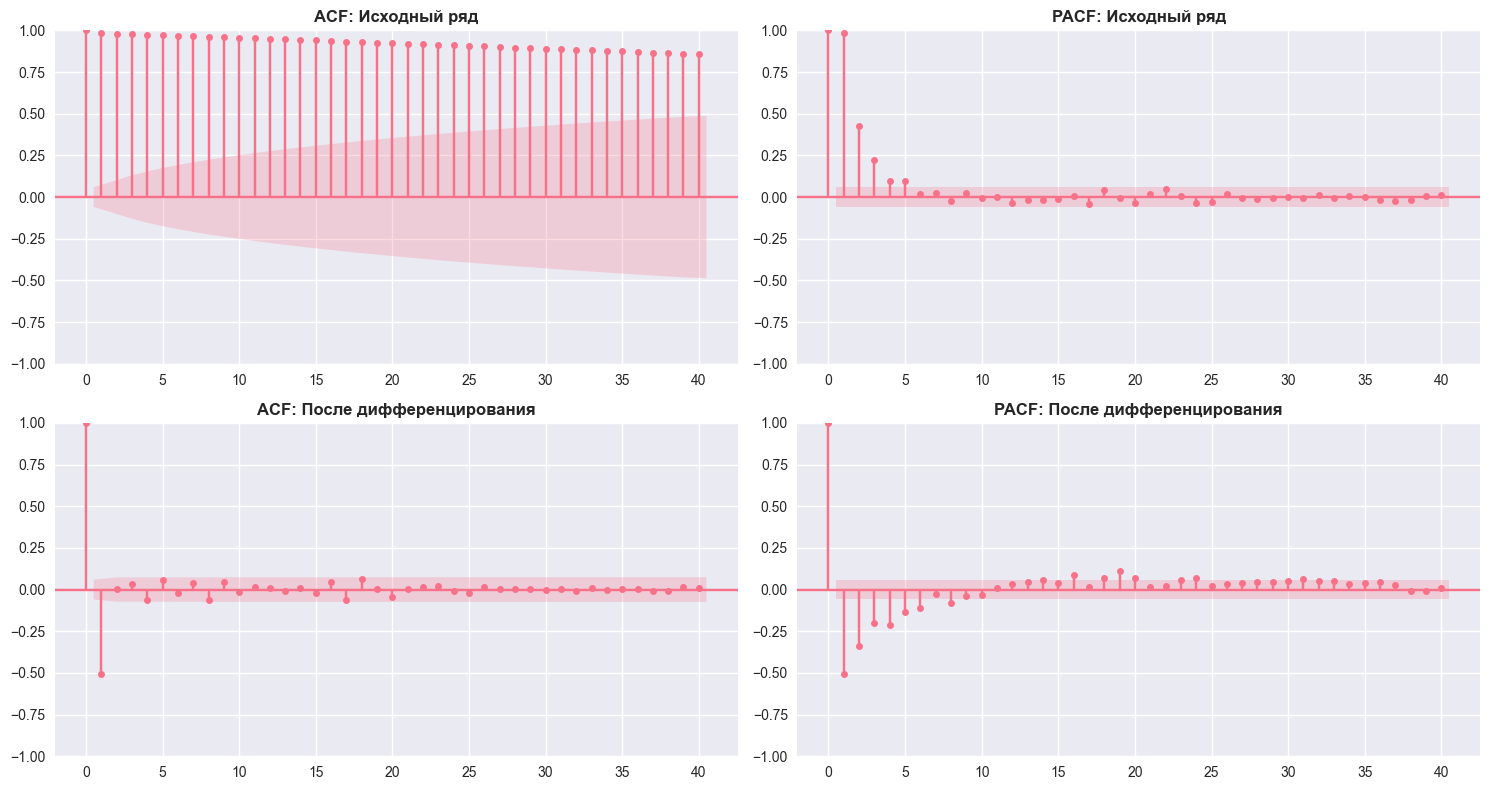

Интерпретация ACF/PACF:
  • ACF медленно затухает → нестационарность или MA
  • PACF резко обрывается → AR модель
  • Сезонные пики → нужна сезонная модель (SARIMA)


In [8]:
# Визуализация ACF и PACF
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# ACF для исходного ряда
plot_acf(df['value'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF: Исходный ряд', fontweight='bold')

# PACF для исходного ряда
plot_pacf(df['value'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF: Исходный ряд', fontweight='bold')

# ACF для дифференцированного ряда
plot_acf(df['diff_1'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: После дифференцирования', fontweight='bold')

# PACF для дифференцированного ряда
plot_pacf(df['diff_1'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF: После дифференцирования', fontweight='bold')

plt.tight_layout()
plt.show()

print("Интерпретация ACF/PACF:")
print("  • ACF медленно затухает → нестационарность или MA")
print("  • PACF резко обрывается → AR модель")
print("  • Сезонные пики → нужна сезонная модель (SARIMA)")

In [9]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df['value'][:train_size], df['value'][train_size:]

print(f"Размер обучающей выборки: {len(train)} ({len(train)/len(df)*100:.1f}%)")
print(f"Размер тестовой выборки: {len(test)} ({len(test)/len(df)*100:.1f}%)")
print(f"Период обучения: {train.index[0].date()} - {train.index[-1].date()}")
print(f"Период теста: {test.index[0].date()} - {test.index[-1].date()}")

Размер обучающей выборки: 876 (80.0%)
Размер тестовой выборки: 219 (20.0%)
Период обучения: 2020-01-01 - 2022-05-25
Период теста: 2022-05-26 - 2022-12-30


Обучение модели ARIMA(1, 1, 1)...

Результаты модели ARIMA
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1918.693
Date:                Mon, 03 Nov 2025   AIC                           3843.385
Time:                        23:39:05   BIC                           3857.708
Sample:                    01-01-2020   HQIC                          3848.864
                         - 05-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0717      0.044     -1.644      0.100      -0.157       0.014
ma.L1         -0.7436      0.030    -25.010      0.000      -0.802      

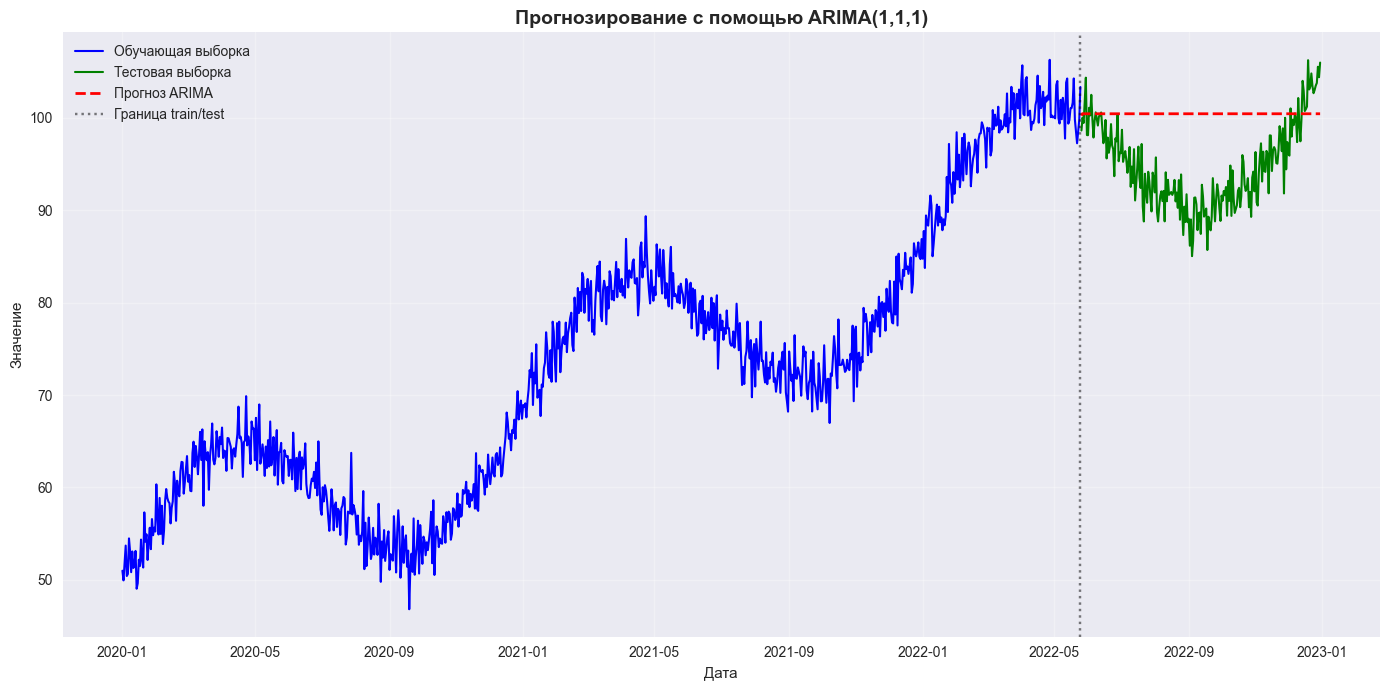


📊 Метрики качества ARIMA:
   MAE:  6.26
   RMSE: 7.27
   MAPE: 6.79%


In [10]:
# Обучение модели ARIMA
print("Обучение модели ARIMA(1, 1, 1)...")
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fitted = arima_model.fit()

print("\n" + "="*60)
print("Результаты модели ARIMA")
print("="*60)
print(arima_fitted.summary())

# Прогноз на тестовый период
forecast_steps = len(test)
arima_forecast = arima_fitted.forecast(steps=forecast_steps)
arima_forecast_index = test.index

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Обучающая выборка', color='blue', linewidth=1.5)
plt.plot(test.index, test, label='Тестовая выборка', color='green', linewidth=1.5)
plt.plot(arima_forecast_index, arima_forecast, label='Прогноз ARIMA', 
         color='red', linewidth=2, linestyle='--')
plt.axvline(x=train.index[-1], color='black', linestyle=':', alpha=0.5, label='Граница train/test')
plt.title('Прогнозирование с помощью ARIMA(1,1,1)', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Метрики качества
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print("\n📊 Метрики качества ARIMA:")
print(f"   MAE:  {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAPE: {mape:.2f}%")

## 5. Машинное обучение для временных рядов

### Feature Engineering для временных рядов

Преобразуем задачу прогнозирования в задачу supervised learning:

**Типы признаков:**
1. **Лаговые признаки**: значения в прошлом (lag-1, lag-7, lag-30)
2. **Скользящие статистики**: rolling mean, rolling std, rolling min/max
3. **Временные признаки**: день недели, месяц, является ли выходным
4. **Разностные признаки**: diff(1), diff(7), pct_change()

### Важно: Time Series Split!

❌ **НЕПРАВИЛЬНО**: обычная кросс-валидация с перемешиванием

✅ **ПРАВИЛЬНО**: TimeSeriesSplit - соблюдаем временной порядок

In [11]:
# Функция для создания признаков
def create_time_series_features(data, lags=[1, 2, 7, 14, 30], rolling_windows=[7, 14, 30]):
    """
    Создание признаков для машинного обучения на временных рядах
    """
    df_features = pd.DataFrame(index=data.index)
    df_features['value'] = data.values
    
    # Лаговые признаки
    for lag in lags:
        df_features[f'lag_{lag}'] = data.shift(lag)
    
    # Скользящие статистики
    for window in rolling_windows:
        df_features[f'rolling_mean_{window}'] = data.rolling(window=window).mean()
        df_features[f'rolling_std_{window}'] = data.rolling(window=window).std()
        df_features[f'rolling_min_{window}'] = data.rolling(window=window).min()
        df_features[f'rolling_max_{window}'] = data.rolling(window=window).max()
    
    # Временные признаки
    df_features['day_of_week'] = data.index.dayofweek
    df_features['day_of_month'] = data.index.day
    df_features['month'] = data.index.month
    df_features['quarter'] = data.index.quarter
    df_features['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
    
    # Разностные признаки
    df_features['diff_1'] = data.diff(1)
    df_features['diff_7'] = data.diff(7)
    df_features['pct_change'] = data.pct_change()
    
    # Экспоненциальное скользящее среднее
    df_features['ema_7'] = data.ewm(span=7).mean()
    df_features['ema_30'] = data.ewm(span=30).mean()
    
    return df_features

# Создание признаков
df_ml = create_time_series_features(df['value'])

print("Созданные признаки:")
print(f"Всего признаков: {df_ml.shape[1]}")
print(f"\nПервые признаки:")
print(df_ml.columns.tolist()[:10])
print(f"\nРазмер датасета: {df_ml.shape}")
print(f"Пропущенные значения: {df_ml.isnull().sum().sum()}")

Созданные признаки:
Всего признаков: 28

Первые признаки:
['value', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7']

Размер датасета: (1095, 28)
Пропущенные значения: 255


In [12]:
# Подготовка данных для ML
df_ml_clean = df_ml.dropna()  # Удаляем пропуски из-за лагов

# Разделение на признаки и целевую переменную
X = df_ml_clean.drop('value', axis=1)
y = df_ml_clean['value']

# Train/test split с сохранением временного порядка
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Данные подготовлены и масштабированы")

Размеры данных:
X_train: (852, 27)
X_test:  (213, 27)
y_train: (852,)
y_test:  (213,)

✅ Данные подготовлены и масштабированы


In [13]:
# Обучение различных ML моделей
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
}

results = {}
predictions = {}

print("Обучение моделей машинного обучения...\n")

for name, model in models.items():
    print(f"Обучение {name}...")
    
    # Обучение
    model.fit(X_train_scaled, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
    
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%\n")

# Создание таблицы результатов
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\n" + "="*70)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*70)
print(results_df.to_string(float_format='%.4f'))

Обучение моделей машинного обучения...

Обучение Ridge...
  MAE: 0.08, RMSE: 0.10, R²: 0.9995, MAPE: 0.08%

Обучение Lasso...
  MAE: 0.18, RMSE: 0.22, R²: 0.9976, MAPE: 0.18%

Обучение Random Forest...
  MAE: 1.44, RMSE: 1.76, R²: 0.8462, MAPE: 1.55%


СРАВНЕНИЕ МОДЕЛЕЙ
                 MAE   RMSE     R²   MAPE
Ridge         0.0781 0.0980 0.9995 0.0831
Lasso         0.1766 0.2194 0.9976 0.1850
Random Forest 1.4386 1.7575 0.8462 1.5464
  MAE: 1.44, RMSE: 1.76, R²: 0.8462, MAPE: 1.55%


СРАВНЕНИЕ МОДЕЛЕЙ
                 MAE   RMSE     R²   MAPE
Ridge         0.0781 0.0980 0.9995 0.0831
Lasso         0.1766 0.2194 0.9976 0.1850
Random Forest 1.4386 1.7575 0.8462 1.5464


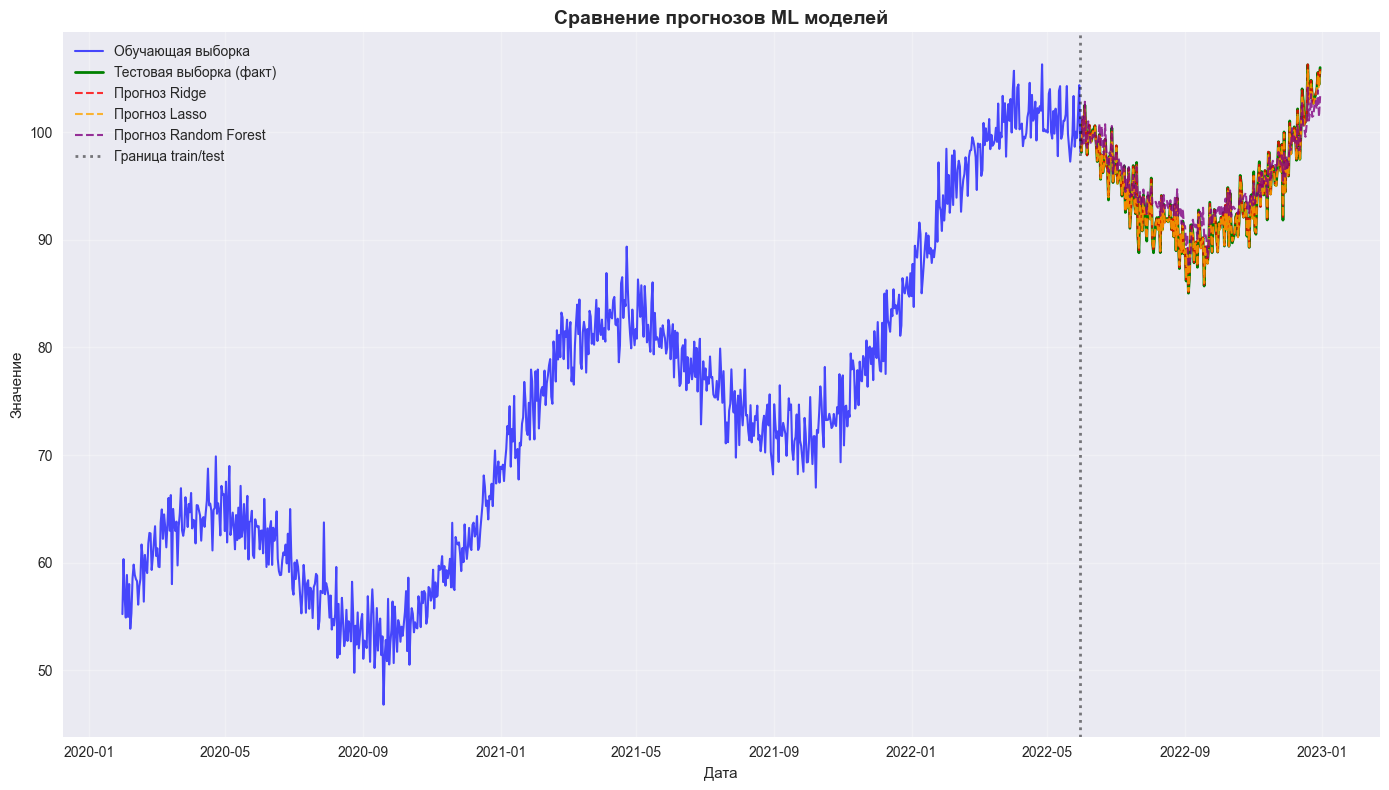

In [14]:
# Визуализация прогнозов всех моделей
plt.figure(figsize=(14, 8))

# Обучающая выборка
plt.plot(y_train.index, y_train, label='Обучающая выборка', 
         color='blue', linewidth=1.5, alpha=0.7)

# Тестовая выборка
plt.plot(y_test.index, y_test, label='Тестовая выборка (факт)', 
         color='green', linewidth=2)

# Прогнозы моделей
colors = ['red', 'orange', 'purple']
for (name, pred), color in zip(predictions.items(), colors):
    plt.plot(y_test.index, pred, label=f'Прогноз {name}', 
             color=color, linewidth=1.5, linestyle='--', alpha=0.8)

plt.axvline(x=y_train.index[-1], color='black', linestyle=':', 
           alpha=0.5, linewidth=2, label='Граница train/test')

plt.title('Сравнение прогнозов ML моделей', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Правильная валидация временных рядов

### ❌ НЕПРАВИЛЬНО: Обычная кросс-валидация

```python
# НЕ ДЕЛАЙТЕ ТАК!
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)  # shuffle=True - DATA LEAKAGE!
```

**Проблема**: обучение на будущем, тестирование на прошлом = утечка данных!

### ✅ ПРАВИЛЬНО: Time Series Split

Схема валидации:
```
Fold 1: [Train: ----    ] [Test: - ]
Fold 2: [Train: ------  ] [Test: - ]
Fold 3: [Train: -------- ] [Test: - ]
Fold 4: [Train: ----------] [Test: - ]
```

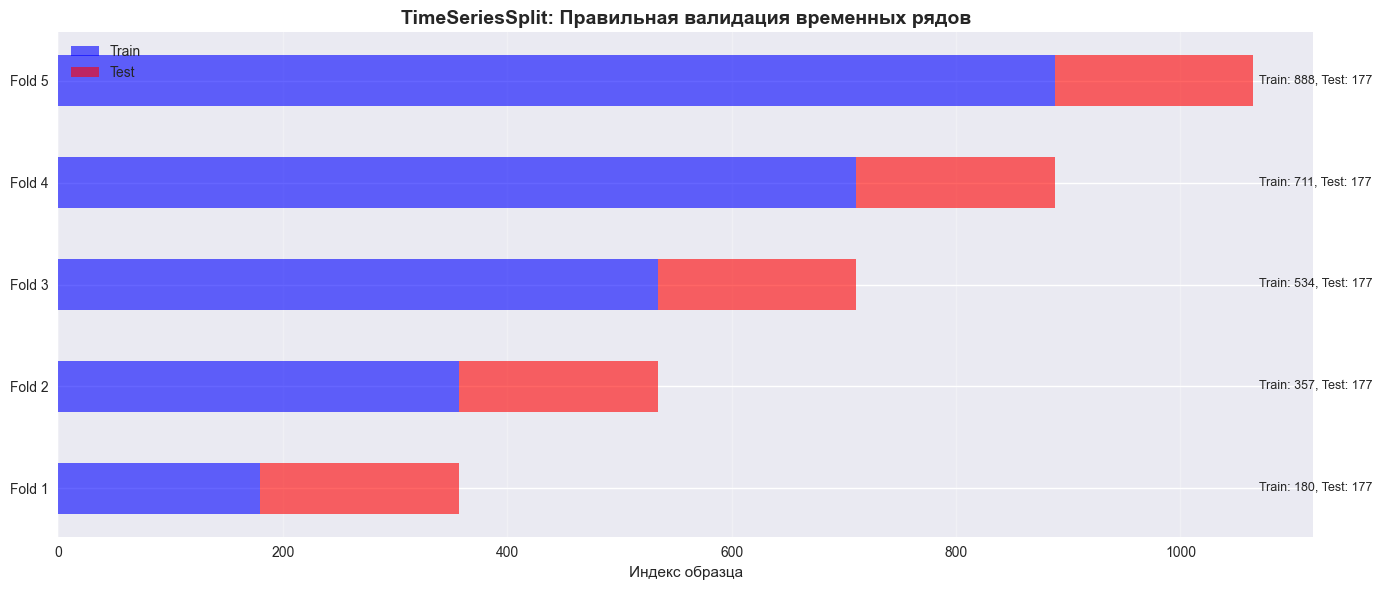


Особенности TimeSeriesSplit:
  ✅ Обучение всегда на прошлых данных
  ✅ Тестирование всегда на будущих данных
  ✅ Временной порядок сохраняется
  ✅ Нет утечки данных (data leakage)


In [15]:
# Демонстрация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Визуализация разбиений
fig, ax = plt.subplots(figsize=(14, 6))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Визуализация train
    ax.barh(fold, len(train_idx), left=train_idx[0], 
            height=0.5, color='blue', alpha=0.6, label='Train' if fold == 0 else '')
    
    # Визуализация test
    ax.barh(fold, len(test_idx), left=test_idx[0], 
            height=0.5, color='red', alpha=0.6, label='Test' if fold == 0 else '')
    
    # Информация о размерах
    ax.text(len(X) + 5, fold, f'Train: {len(train_idx)}, Test: {len(test_idx)}', 
           va='center', fontsize=9)

ax.set_yticks(range(5))
ax.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax.set_xlabel('Индекс образца')
ax.set_title('TimeSeriesSplit: Правильная валидация временных рядов', 
            fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nОсобенности TimeSeriesSplit:")
print("  ✅ Обучение всегда на прошлых данных")
print("  ✅ Тестирование всегда на будущих данных")
print("  ✅ Временной порядок сохраняется")
print("  ✅ Нет утечки данных (data leakage)")

Результаты кросс-валидации с TimeSeriesSplit:
Fold 1: MAE = 2.04
Fold 2: MAE = 7.08
Fold 3: MAE = 1.26
Fold 4: MAE = 1.14
Fold 5: MAE = 9.48
Средний MAE: 4.20 ± 3.43
Минимальный MAE: 1.14
Максимальный MAE: 9.48


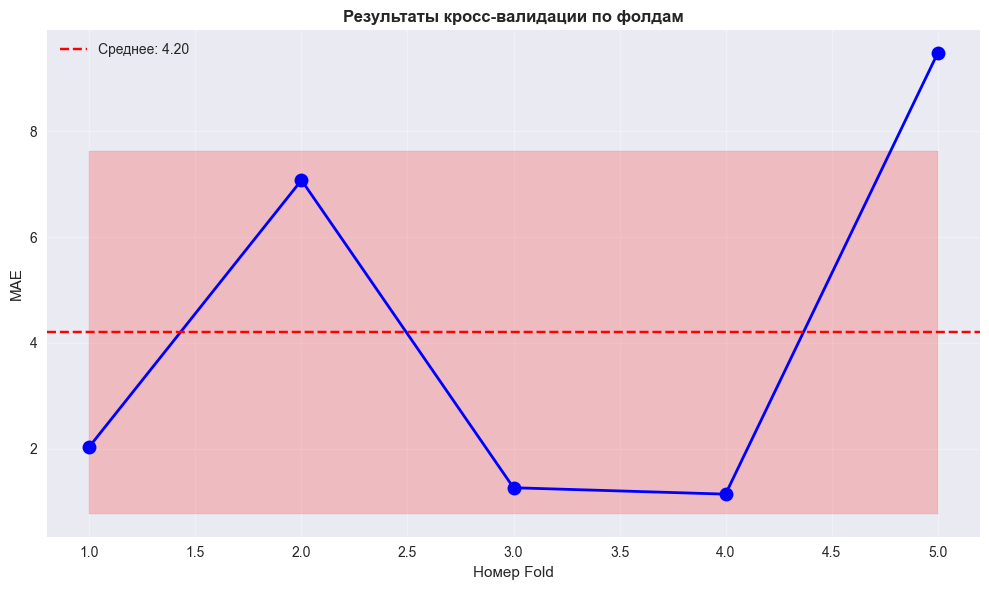

In [16]:
# Кросс-валидация с TimeSeriesSplit
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# Вычисление scores для каждого fold
scores = cross_val_score(model, X_train_scaled, y_train, 
                        cv=tscv, scoring='neg_mean_absolute_error')

mae_scores = -scores  # Переводим обратно в положительные значения

print("Результаты кросс-валидации с TimeSeriesSplit:")
print("="*60)
for i, score in enumerate(mae_scores):
    print(f"Fold {i+1}: MAE = {score:.2f}")

print("="*60)
print(f"Средний MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")
print(f"Минимальный MAE: {mae_scores.min():.2f}")
print(f"Максимальный MAE: {mae_scores.max():.2f}")

# Визуализация результатов CV
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), mae_scores, 'bo-', markersize=10, linewidth=2)
plt.axhline(y=mae_scores.mean(), color='r', linestyle='--', 
           label=f'Среднее: {mae_scores.mean():.2f}')
plt.fill_between(range(1, 6), 
                mae_scores.mean() - mae_scores.std(),
                mae_scores.mean() + mae_scores.std(),
                alpha=0.2, color='red')
plt.xlabel('Номер Fold')
plt.ylabel('MAE')
plt.title('Результаты кросс-валидации по фолдам', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Важность признаков

Анализ важности признаков помогает понять, какие факторы наиболее важны для прогнозирования.

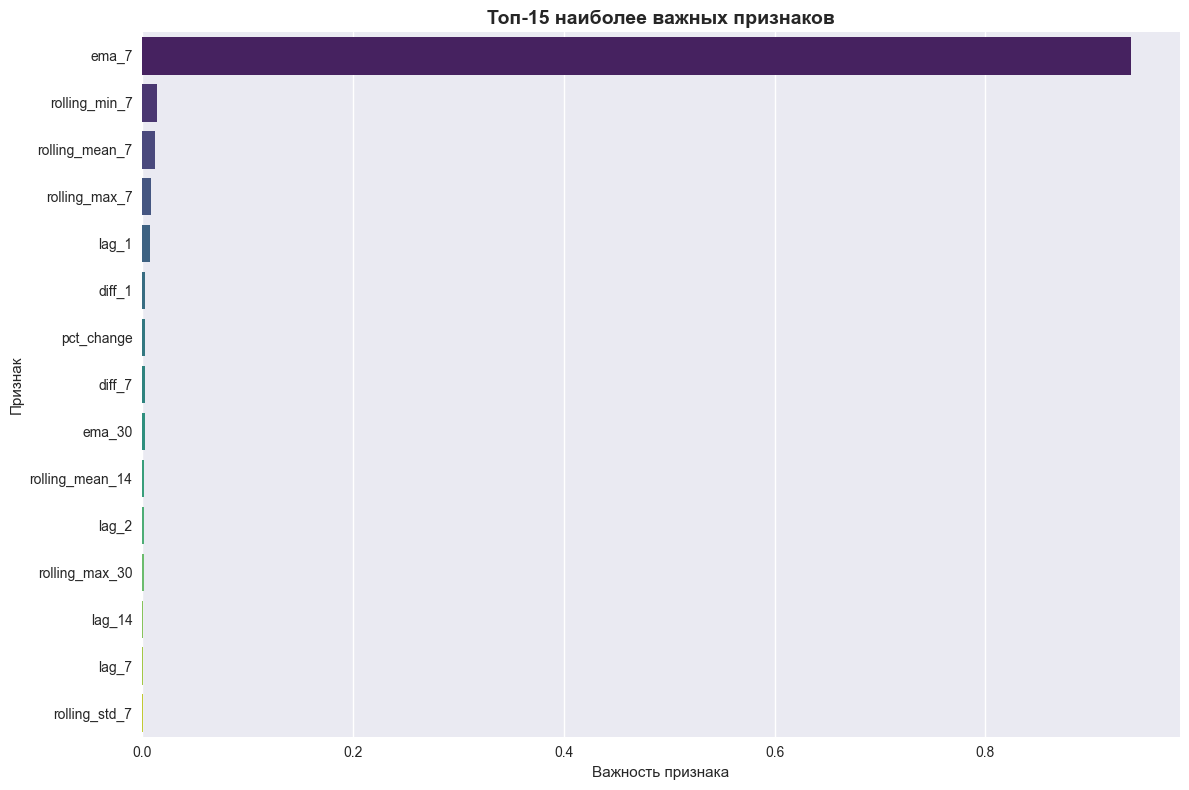


Топ-10 наиболее важных признаков:
ema_7                          0.9377
rolling_min_7                  0.0142
rolling_mean_7                 0.0127
rolling_max_7                  0.0083
lag_1                          0.0072
diff_1                         0.0029
pct_change                     0.0027
diff_7                         0.0026
ema_30                         0.0024
rolling_mean_14                0.0022

Выводы:
  • Лаговые признаки часто самые важные
  • Rolling статистики захватывают паттерны
  • Временные признаки помогают с сезонностью


In [17]:
# Обучение Random Forest для анализа важности признаков
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Получение важности признаков
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Визуализация топ-15 признаков
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Топ-15 наиболее важных признаков', fontsize=14, fontweight='bold')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

print("\nТоп-10 наиболее важных признаков:")
print("="*60)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{row['feature']:30s} {row['importance']:.4f}")

print("\nВыводы:")
print("  • Лаговые признаки часто самые важные")
print("  • Rolling статистики захватывают паттерны")
print("  • Временные признаки помогают с сезонностью")

## Заключение

### Ключевые выводы:

1. **Временные ряды требуют особого подхода**
   - Временная зависимость критична
   - Порядок данных нельзя нарушать
   - Специальные методы валидации

2. **Декомпозиция помогает понять структуру**
   - Тренд, сезонность, остатки
   - Аддитивная vs мультипликативная
   - STL decomposition

3. **Стационарность важна для ARIMA**
   - Тесты: ADF, KPSS
   - Дифференцирование для достижения стационарности
   - Логарифмирование для стабилизации дисперсии

4. **ARIMA - классический подход**
   - AR + MA + дифференцирование
   - ACF/PACF для выбора параметров
   - SARIMA для сезонных данных

5. **ML модели через feature engineering**
   - Лаговые признаки
   - Rolling статистики
   - Временные признаки
   - Часто превосходят ARIMA

6. **Валидация - TimeSeriesSplit!**
   - Нельзя использовать обычную CV
   - Соблюдаем временной порядок
   - Избегаем data leakage

### Когда использовать какой метод:

| Метод | Когда использовать |
|-------|-------------------|
| **ARIMA** | Короткие стационарные ряды, без внешних факторов |
| **SARIMA** | Данные с сезонностью, стационарные после преобразований |
| **ML (RF, XGBoost)** | Много внешних признаков, нелинейные зависимости |
| **Prophet** | Бизнес-данные с праздниками, автоматическая обработка |
| **LSTM/Трансформеры** | Очень длинные последовательности, сложные паттерны |